In [1]:
import cv2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import random
import math
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback

1/1 [==============================] - 0s 406ms/step
<dtype: 'float32'>


Text(0.5, 1.0, 'Painting')

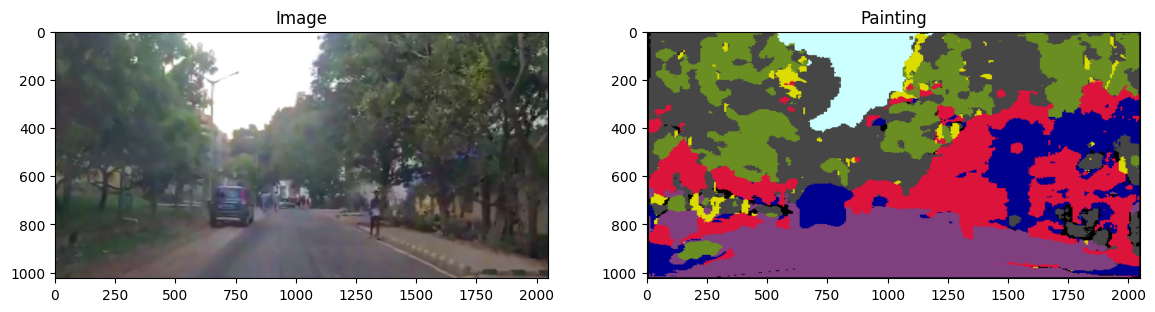

In [2]:
model = load_model('../models/stylization_model_v2')

path = ''
#img_path = '../sample_data/images/frame0.jpg'
img_path = '../sample_data/images/test_video-1.png'
image_path = os.path.join(path, img_path)
img = tf.io.read_file(image_path)

img = tf.image.decode_png(img, channels=3)

img = cv2.fastNlMeansDenoisingColored(img.numpy(),None,7,7,7,21)

if img_path == '../sample_data/images/test_video-1.png':
            
    img =  tf.image.adjust_brightness(img,0.1) 
    img =  tf.image.adjust_contrast(img,1.1)
    img = tf.image.adjust_saturation(img,1.5)
            
elif img_path == '../sample_data/images/frame0.jpg':
            
    img =  tf.image.adjust_brightness(img,-0.25) 
    img =  tf.image.adjust_contrast(img,1.1)
    img = tf.image.adjust_saturation(img,1.5)

img = tf.image.resize(img, [288, 288])
img /= 255.
img = tf.expand_dims(img, axis=0)

pred_mask = model.predict(img)

pred_mask = tf.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[..., tf.newaxis]

mask_2d = np.squeeze(pred_mask[0], axis=-1)
final_mask = np.stack((mask_2d,)*3, axis=-1)
#print(final_mask.shape)
height, width, _ = final_mask.shape
prev = 0
for i in range(height):
    for j in range(width):   
        if final_mask[i,j,0] == 4:
            final_mask[i,j,0] = 0
            final_mask[i,j,1] = 0
            final_mask[i,j,2] = 0
        elif final_mask[i,j,0] in (1,6,7,8,9,10):
            final_mask[i,j,0] = 128
            final_mask[i,j,1] = 64
            final_mask[i,j,2] = 128
        elif final_mask[i,j,0] in (11,12,13,14,15,16):
            final_mask[i,j,0] = 70
            final_mask[i,j,1] = 70
            final_mask[i,j,2] = 70
        elif final_mask[i,j,0] in (17,18,19,20):
            final_mask[i,j,0] = 220
            final_mask[i,j,1] = 220
            final_mask[i,j,2] = 0
        elif final_mask[i,j,0] in (21,22):
            final_mask[i,j,0] = 107
            final_mask[i,j,1] = 142
            final_mask[i,j,2] = 35
        elif final_mask[i,j,0]  == 23:
            final_mask[i,j,0] = 204
            final_mask[i,j,1] = 255
            final_mask[i,j,2] = 255
        elif final_mask[i,j,0]  in (24,25):
            final_mask[i,j,0] = 220
            final_mask[i,j,1] = 20
            final_mask[i,j,2] = 60
        elif final_mask[i,j,0]  in (26,27,28,29,30,31,32,33):
            final_mask[i,j,0] = 0
            final_mask[i,j,1] = 0
            final_mask[i,j,2] = 142   
        else:
            final_mask[i,j,0] = 0
            final_mask[i,j,1] = 0
            final_mask[i,j,2] = 0
            
        

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
print(img[0].dtype)
image = tf.image.resize(img[0],[1024,2048])
arr[0].imshow(tf.keras.preprocessing.image.array_to_img(image))
arr[0].set_title('Image')
final_mask = cv2.resize(final_mask, (2048, 1024), interpolation=cv2.INTER_NEAREST)
arr[1].imshow(tf.keras.preprocessing.image.array_to_img(final_mask))
arr[1].set_title('Painting')


In [3]:
def preprocess_video(frame):
    img = tf.image.resize(frame, [288, 288])
    img /= 255.  
    img = tf.expand_dims(img, axis=0)
    return img

def oilpaint(pred_mask):
    mask_2d = np.squeeze(pred_mask[0], axis=-1)
    final_mask = np.stack((mask_2d,)*3, axis=-1)
    print(final_mask.shape)
    height, width, _ = final_mask.shape
    for i in range(height):
        for j in range(width):   
            if final_mask[i,j,0] == 4:
                final_mask[i,j,2] = 0
                final_mask[i,j,1] = 0
                final_mask[i,j,0] = 0
            elif final_mask[i,j,0] in (1,6,7,8,9,10):
                final_mask[i,j,2] = 128
                final_mask[i,j,1] = 64
                final_mask[i,j,0] = 128
            elif final_mask[i,j,0] in (11,12,13,14,15,16):
                final_mask[i,j,2] = 70
                final_mask[i,j,1] = 70
                final_mask[i,j,0] = 70
            elif final_mask[i,j,0] in (17,18,19,20):
                final_mask[i,j,2] = 220
                final_mask[i,j,1] = 220
                final_mask[i,j,0] = 0
            elif final_mask[i,j,0] in (21,22):
                final_mask[i,j,2] = 107
                final_mask[i,j,1] = 142
                final_mask[i,j,0] = 35
            elif final_mask[i,j,0]  == 23:
                final_mask[i,j,2] = 204
                final_mask[i,j,1] = 255
                final_mask[i,j,0] = 255
            elif final_mask[i,j,0]  in (24,25):
                final_mask[i,j,2] = 220
                final_mask[i,j,1] = 20
                final_mask[i,j,0] = 60
            elif final_mask[i,j,0]  in (26,27,28,29,30,31,32,33):
                final_mask[i,j,2] = 0
                final_mask[i,j,1] = 0
                final_mask[i,j,0] = 142
            else:
                final_mask[i,j,0] = 0
                final_mask[i,j,1] = 0
                final_mask[i,j,2] = 0
    return final_mask

In [6]:
#video_path = '../sample_data/videos/test-2.mp4'
video_path = '../sample_data/videos/test-1.mp4'

if video_path == '../sample_data/videos/test-1.mp4':
    
    model = load_model('../models/stylization_model_v2')
    
elif video_path == '../sample_data/videos/test-2.mp4':
    
    model = load_model('../models/stylization_model_v1')
    

cap = cv2.VideoCapture(video_path)

while cap.isOpened():

    ret, frame = cap.read()

    if ret:
             
        img = cv2.fastNlMeansDenoisingColored(frame,None,7,7,7,21)
        
        if video_path == '../sample_data/videos/test-1.mp4':
            
            img =  tf.image.adjust_brightness(img,0.1) 
            img =  tf.image.adjust_contrast(img,1.1)
            img = tf.image.adjust_saturation(img,1.5)
            
        elif video_path == '../sample_data/videos/test-2.mp4':
            
            img =  tf.image.adjust_brightness(img,-0.15) 
            img =  tf.image.adjust_contrast(img,1.05)
            img = tf.image.adjust_saturation(img,1.6)
              
        preprocessed_frame = preprocess_video(img)
      
        prediction = model.predict(preprocessed_frame)
        prediction = tf.argmax(prediction, axis=-1)
        prediction = prediction[..., tf.newaxis]
        
        output = oilpaint(prediction)
        output = cv2.resize(output, (640, 352), interpolation=cv2.INTER_NEAREST)
            
        output = output.astype(np.uint8)
        display_frame = np.hstack((frame, output))
        cv2.imshow('Sparse', display_frame)

        key = cv2.waitKey(1)

        if key == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 283ms/step
(288, 288, 3)
1/1 [==============================] - 0s 145ms/step
(288, 288, 3)
1/1 [==============================] - 0s 125ms/step
(288, 288, 3)
1/1 [==============================] - 0s 141ms/step
(288, 288, 3)
1/1 [==============================] - 0s 133ms/step
(288, 288, 3)
1/1 [==============================] - 0s 125ms/step
(288, 288, 3)
1/1 [==============================] - 0s 116ms/step
(288, 288, 3)
1/1 [==============================] - 0s 125ms/step
(288, 288, 3)
1/1 [==============================] - 0s 120ms/step
(288, 288, 3)
1/1 [==============================] - 0s 141ms/step
(288, 288, 3)
1/1 [==============================] - 0s 141ms/step
(288, 288, 3)
1/1 [==============================] - 0s 125ms/step
(288, 288, 3)
1/1 [==============================] - 0s 119ms/step
(288, 288, 3)
1/1 [==============================] - 0s 128ms/step
(288, 288, 3)
1/1 [==============================] - 0s 141ms/step
(288, 288